<a href="https://colab.research.google.com/github/ArtOliinyk/MM_coursework/blob/main/%D0%9C%D0%9C_%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

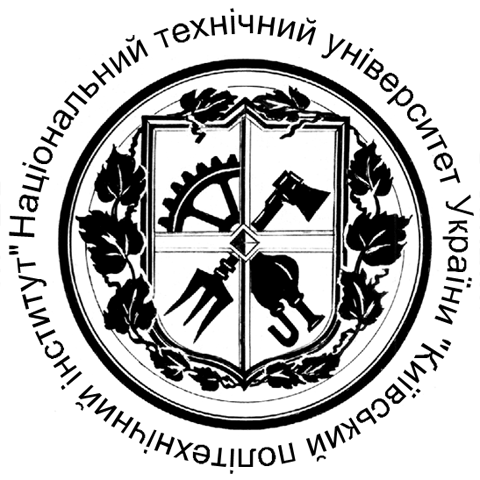

Курсова робота з дисципліни "Математичне моделювання";

Виконав студент групи КМ-91: Олійник Артем

### **«Оптимізація роботи відділення Нової пошти»**

### **Зміст**

1. Вступ
2. Постановка задачі
3. Метод розв'язку
4. Програмний код
5. Висновки
6. Посилання

### **Вступ**

Зазвичай, збір посилок у оператора Нової пошти може забирать до 60% всього часу, оптимізація маршруту цього збору може скоротити час обслуговування клієнта і відповідно пропускну здатність тих самих клієнтів.

### **Постановка задачі**

Розробити програмне забезпечення, за допомогою якого можна оптимізувати маршрут збору посилок для клієнтів. Будемо вважати, що за оператором знаходиться склад з посилками, який має наступний вигляд:
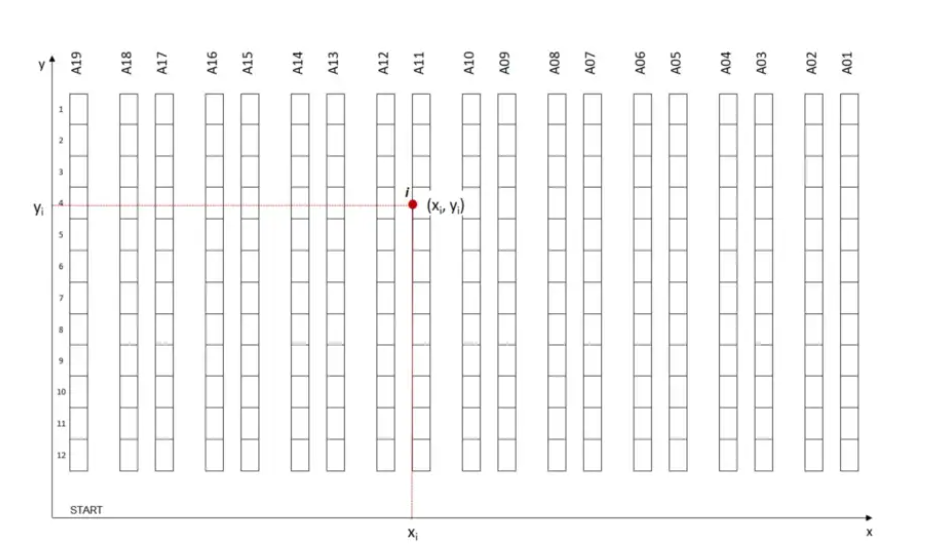

### **Метод розв'язку**

Один з способів оптимізувати процес обрання маршруту — об’єднати замовлення в одному маршруті комплектування — цю стратегію зазвичай називають хвильовим набором.

Базуючись на фактичному плані складу, місця зберігання наносяться на карту з 2-D (x, y) координатами, які використовуватимуться для вимірювання пішої відстані.

Для цього ми будемо будувати хвилі та створювати маршрути, які будуть складатися зі списку замовлень. Також ми будемо змінювати кількість замовлень у хвилі для демонстрації того, на скільки скоротиться загальна відстань збирання посилок

### **Програмний код**

In [ ]:
# імпорт бібліотек
import numpy as np
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
from ast import literal_eval
from IPython.display import display, HTML

In [ ]:
# Розрахунок відстані між двома локаціями
def distance_picking(Loc1, Loc2, y_low, y_high):

    # Начальна точка
    x1, y1 = Loc1[0], Loc1[1]
    # Кінчеца точка
    x2, y2 = Loc2[0], Loc2[1]
    # Дистанція по x-координаті
    distance_x = abs(x2 - x1)
    # Дистанція по y-координаті
    if x1 == x2:
        distance_y1 = abs(y2 - y1)
        distance_y2 = distance_y1
    else:
        distance_y1 = (y_high - y1) + (y_high - y2)
        distance_y2 = (y1 - y_low) + (y2 - y_low)
    # Мінімальна дистанція по y-координаті
    distance_y = min(distance_y1, distance_y2)    
    # Загальна дистанція
    distance = distance_x + distance_y

    return distance

In [ ]:
# Знаходження наступної найближчої локації
def next_location(start_loc, list_locs, y_low, y_high):

    # Дистанція до всіх точок-кандидатів
    list_dist = [distance_picking(start_loc, i, y_low, y_high) for i in list_locs]
    # Мінімальна дистанція
    distance_next = min(list_dist)
    # Локаця точки з мінімальною відстанню
    index_min = list_dist.index(min(list_dist))
    next_loc = list_locs[index_min] # Наступна локація з відстанню = min (**)
    list_locs.remove(next_loc)      # Наступна локація вилучається зі списку
    
    return list_locs, start_loc, next_loc, distance_next

In [ ]:
# Загальна відстань, яка покриває перелік локацій
def create_picking_route(origin_loc, list_locs, y_low, y_high):

    # Змінна загальної відстані
    wave_distance = 0
    # Змінна теперешньої локації
    start_loc = origin_loc
    # Збереження маршрутів
    list_chemin = []
    list_chemin.append(start_loc)
    
    while len(list_locs) > 0: # Цикл за всіма обраними локаціями
        # Перехід на наступну локацію
        list_locs, start_loc, next_loc, distance_next = next_location(start_loc, list_locs, y_low, y_high)
        # Оновлення start_loc 
        start_loc = next_loc
        list_chemin.append(start_loc)
        # Оновлення відстані
        wave_distance = wave_distance + distance_next 

    # Фінальна відстань між останнєю локацією та точкою початку
    wave_distance = wave_distance + distance_picking(start_loc, origin_loc, y_low, y_high)
    list_chemin.append(origin_loc)
    
    return wave_distance, list_chemin

In [ ]:
# Mapping замовлень за номером хвилі
def orderlines_mapping(df_orderlines, orders_number):

  # Сортування даних за часом
  df_orderlines = df_orderlines.sort_values(by='DATE', ascending = True)
  # Список номерів унікальних замовлень
  list_orders = df_orderlines.OrderNumber.unique()
  # Словник(dictionary) для mapping
  dict_map = dict(zip(list_orders, [i for i in range(1, len(list_orders)+1)]))
  # ID замовлення mapping
  df_orderlines['OrderID'] = df_orderlines['OrderNumber'].map(dict_map)
  df_orderlines = df_orderlines.sort_values(by='OrderID', ascending = True)
  # Групування замовлень за хвилею orders_number
  df_orderlines['WaveID'] = (df_orderlines.OrderID/orders_number).apply(np.ceil).astype(int)

  # Розрахунок кількості хвиль
  waves_number = df_orderlines.WaveID.max() + 1

  return df_orderlines, waves_number

In [ ]:
# Збір локацій для обходу для хвилі замовлень
def locations_listing(df_orderlines, wave_id):

	# Фільтрація за wave_id
	df = df_orderlines[df_orderlines.WaveID == wave_id]
	# Створення списку координат
	list_locs = list(df['Coord'].apply(lambda t: literal_eval(t)).values)
	list_locs.sort()
	# Отримання унікальних координат
	list_locs = list(k for k,_ in itertools.groupby(list_locs))
	n_locs = len(list_locs)

	return list_locs, n_locs

In [ ]:
# Зчитання даних
df_orderlines = pd.read_csv('sample_data/df_lines.csv')

# Параметри
y_low, y_high = 5.5, 50 		# Входи по y-координаті
Loc_orn = [0, y_low] 			# Початкова локація

# Списки для зберігання даних
list_wid, list_dst, list_route, list_ord = [], [], [], []

# Функція
def simulation_wave(y_low, y_high, orders_number, df_orderlines, list_wid, list_dst, list_route, list_ord):


  # Загальна відстань
  distance_route = 0 
  # Створення хвиль
  df_orderlines, waves_number = orderlines_mapping(df_orderlines, orders_number)
  for wave_id in range(waves_number):
    # Оброблення всіх локацій хвилі 
    list_locs, n_locs = locations_listing(df_orderlines, wave_id)
    # Результати
    wave_distance, list_chemin = create_picking_route(Loc_orn, list_locs, y_low, y_high)
    distance_route = distance_route + wave_distance
    # Додавання результатів до списків
    list_wid.append(wave_id)
    list_dst.append(wave_distance)
    list_route.append(list_chemin)
    list_ord.append(orders_number)

  return list_wid, list_dst, list_route, list_ord, distance_route

plot_data = []
# Тестування різних значень для кількості замовленнь у хвилі
for orders_number in range(1, 11):
  list_wid, list_dst, list_route, list_ord, distance_route = simulation_wave(y_low, y_high, orders_number, df_orderlines, list_wid, list_dst, list_route, list_ord)
  print("Загальна відстань для {} замовлення на хвилю: {:,} m".format(orders_number, distance_route))
  plot_data.append([orders_number, distance_route])

# df для графіку
df_plot = pd.DataFrame(plot_data)

# df для результатів
df_results = pd.DataFrame({'Номер хвилі': list_wid,
          'Відстань': list_dst,
          'Локації': list_route,
          'Замовлень на хвилю': list_ord})

Загальна відстань для 1 замовлення на хвилю: 319,466.0 m
Загальна відстань для 2 замовлення на хвилю: 217,800.0 m
Загальна відстань для 3 замовлення на хвилю: 177,609.0 m
Загальна відстань для 4 замовлення на хвилю: 154,002.0 m
Загальна відстань для 5 замовлення на хвилю: 137,515.5 m
Загальна відстань для 6 замовлення на хвилю: 125,858.5 m
Загальна відстань для 7 замовлення на хвилю: 116,600.5 m
Загальна відстань для 8 замовлення на хвилю: 108,554.0 m
Загальна відстань для 9 замовлення на хвилю: 102,416.0 m
Загальна відстань для 10 замовлення на хвилю: 97,488.0 m


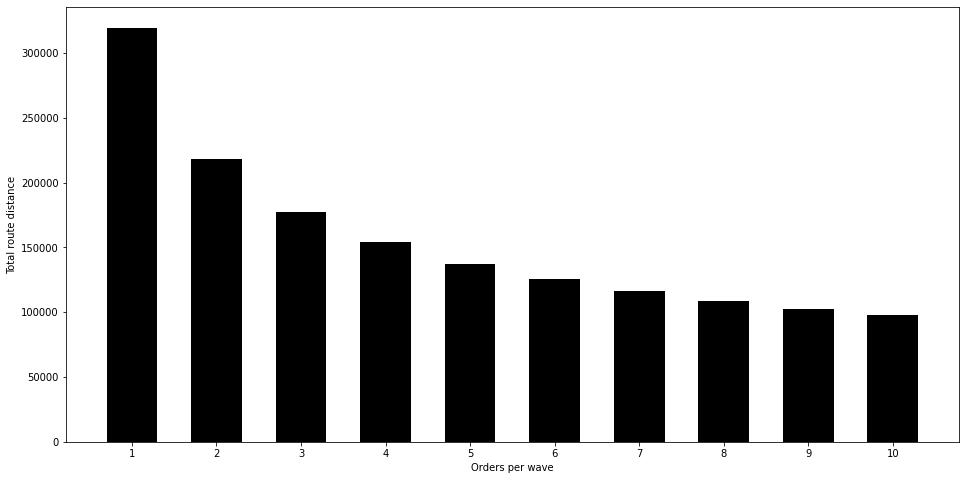

In [ ]:
fig = plt.figure(figsize = (16, 8))
 
# Створення графіку
plt.bar(df_plot[0], df_plot[1], color ='black',
        width = 0.6)
 
plt.xlabel("Orders per wave")
plt.xticks(df_plot[0])
plt.ylabel("Total route distance")
plt.show()

### **Висновки**

Було розглянуто задачу оптимізації роботи відділення Нової пошти. Також було розроблено програму, яка визначає маршрут для збирання замовлень в залежності від їх кількості. Як можна побачити на нашому останньому графіку, якщо збирати по декілька замовлень за раз загальна відстань пройдена оператором Нової пошти зменшується, отже він заощаджує час, що потенційно може збільшити прибутки компанії

### **Посилання**
Single Picker Routing Problem [Електронний ресурс] // PubsOnline – Режим доступу до ресурсу: https://pubsonline.informs.org/doi/abs/10.1287/ijoc.2020.1040.

Ho, Y. C., Teng Sheng Su, and Zhi Bin Shi. (2008). "Order-Batching Methods for an Order-Picking Warehouse
with Two Cross Aisles." Computers and Industrial Engineering 55(2):321–47.

Goetschalckx, Marc, and H. Donald Ratliff. (1988). "Order Picking in an Aisle." IIE Transactions 20:53--62